In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image

np.random.seed(1)

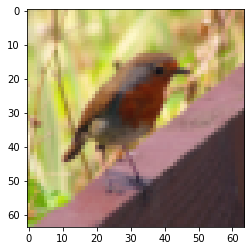

In [14]:
# The helper functions

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def loadData():
    with h5py.File("./data/train_catvnoncat.h5", "r") as file:
        train_set_x_orig = np.array(file["train_set_x"][:])
        train_set_y_orig = np.array(file["train_set_y"][:])

    with h5py.File("./data/test_catvnoncat.h5", "r") as file:
        test_set_x_orig = np.array(file["test_set_x"][:])
        test_set_y_orig = np.array(file["test_set_y"][:])
        classes = np.array(file["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
        
train_x_orig, train_y, test_x_orig, test_y, classes = loadData()

# Show an example
idx = 10
plt.imshow(train_x_orig[10])
plt.show()

# Pre process the training and test datas
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T 
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

In [15]:
def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * .01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * .01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
    return parameters   

def initialize_parameters_deep(layer_dims:list):

    np.random.seed(3)
    parameters = {}
    l = len(layer_dims) # No. of layers

    for i in range(1,l):
        parameters[f"W{i}"] = np.random.randn(layer_dims[i],layer_dims[i-1]) * .01
        parameters[f"b{i}"] = np.zeros((layer_dims[i],1))
    
    return parameters

def linear_forward(A, W, b):

    Z = np.dot(W,A) + b
    
    cache = (A, W, b)
    
    return Z, cache

def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    
    caches = []
    A = X
    L = len(parameters) // 2
    
    for i in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters[f"W{i}"], parameters[f"b{i}"], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters[f"W{i+1}"], parameters[f"b{i+1}"], "sigmoid")
    caches.append(cache)
          
    return AL, caches

def compute_cost(AL, Y):
    # Compute the cross enthropy loss
    
    m = Y.shape[1]
    
    cost = -1/m*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    
    cost = np.squeeze(cost)
    
    return cost

def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m*np.matmul(dZ,A_prev.T)
    db = 1/m*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.matmul(W.T,dZ)
    
    return dA_prev, dW, db
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, caches[-1], "sigmoid")
    grads[f"dA{L-1}"] = dA_prev_temp
    grads[f"dW{L}"] = dW_temp
    grads[f"db{L}"] = db_temp
    
    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, caches[l], "relu")
        grads[f"dA{l}"] = dA_prev_temp
        grads[f"dW{l+1}"] = dW_temp
        grads[f"db{l+1}"] = db_temp
        
    return grads

def update_parameters(params, grads, learning_rate):
    
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(1,L+1):
        
        parameters[f"W{l}"] = params[f"W{l}"] - learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] = params[f"b{l}"] - learning_rate * grads[f"db{l}"]
        
    return parameters

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        cost = compute_cost(A2, Y)
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()